In [9]:
import pprint

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader

from models.crater_model import CraterModel
from utils.dataset import CraterDataset


In [2]:
IMG_DIM = 128

In [3]:
train_dataset = CraterDataset(
    img_dir=f"./dataset/geo_train_{IMG_DIM}", mask_dir=f"./dataset/mask_train_{IMG_DIM}"
)
val_dataset = CraterDataset(
    img_dir=f"./dataset/geo_val_{IMG_DIM}", mask_dir=f"./dataset/mask_val_{IMG_DIM}"
)
test_dataset = CraterDataset(
    img_dir=f"./dataset/geo_test_{IMG_DIM}", mask_dir=f"./dataset/mask_test_{IMG_DIM}"
)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Train size: 800
Val size: 100
Test size: 100


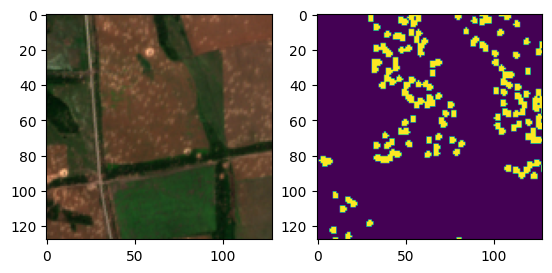

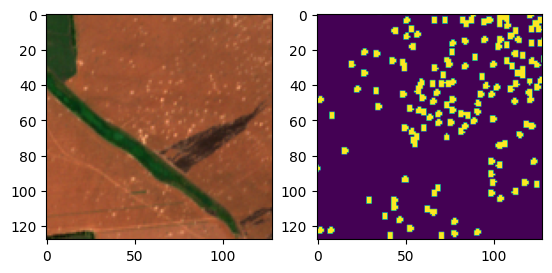

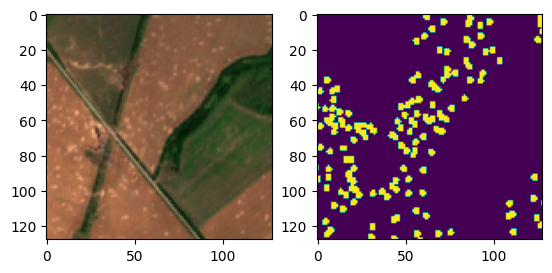

In [4]:
sample = train_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = val_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = test_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(sample["mask"].squeeze())
plt.show()

In [5]:
model = CraterModel(arch="FPN", encoder_name="resnet34", in_channels=3, out_classes=1)

In [6]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/50 [00:00<?, ?it/s] 

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 9: 100%|██████████| 50/50 [00:04<00:00, 11.15it/s, v_num=15, valid_per_image_iou=0.414, valid_dataset_iou=0.418, train_per_image_iou=0.406, train_dataset_iou=0.408]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:05<00:00,  9.40it/s, v_num=15, valid_per_image_iou=0.414, valid_dataset_iou=0.418, train_per_image_iou=0.406, train_dataset_iou=0.408]


In [7]:
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 25.74it/s]
[{'valid_per_image_iou': 0.41424891352653503, 'valid_dataset_iou': 0.417855829000473}]


In [8]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 25.60it/s]
[{'test_per_image_iou': 0.4122033715248108, 'test_dataset_iou': 0.4156467914581299}]


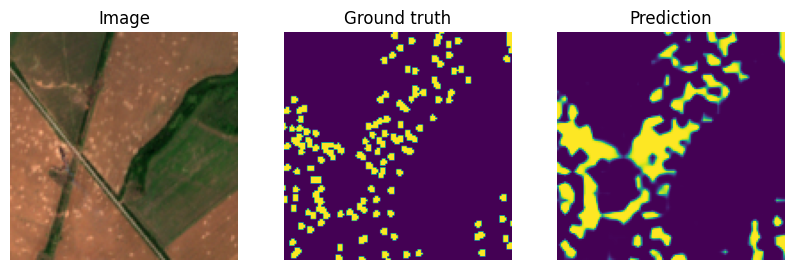

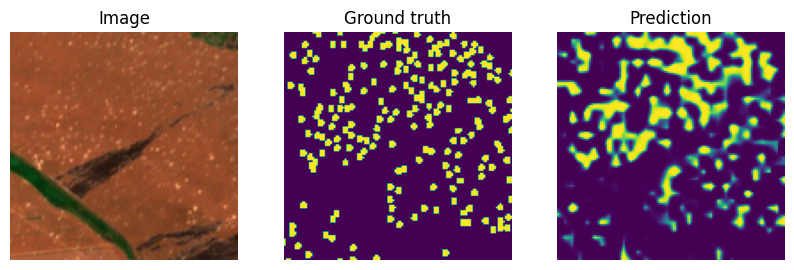

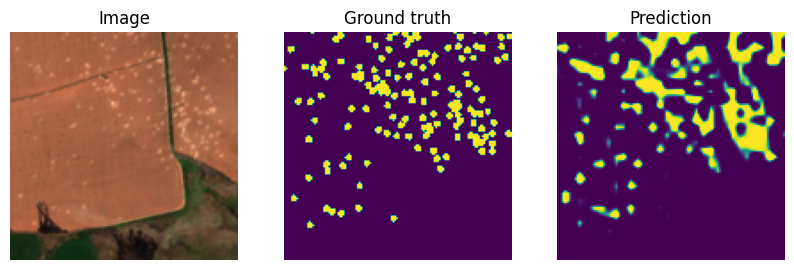

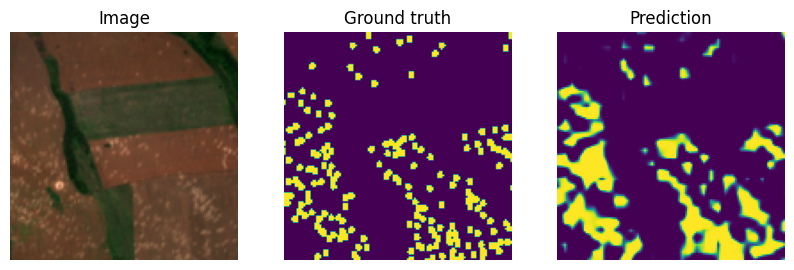

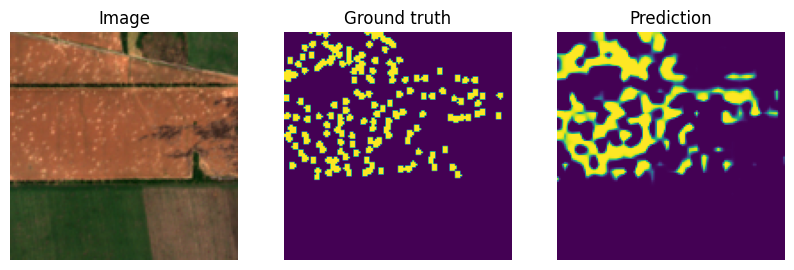

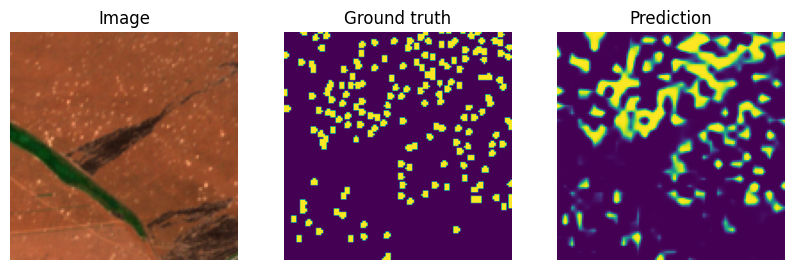

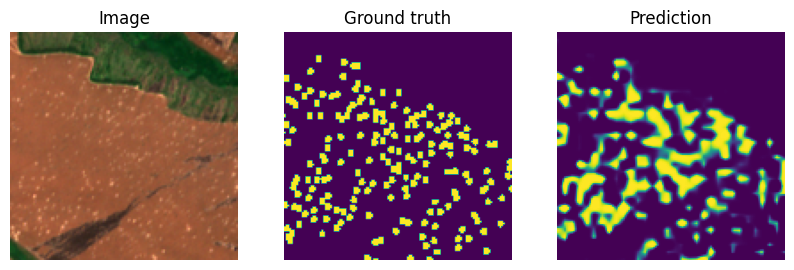

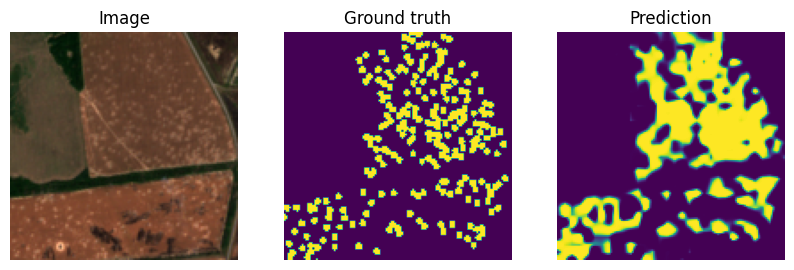

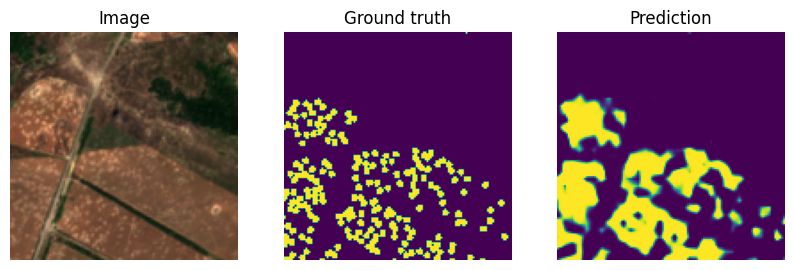

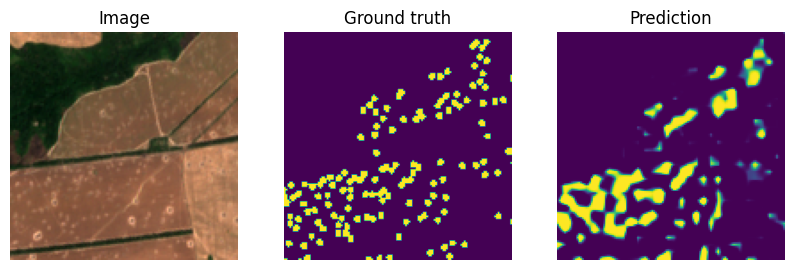

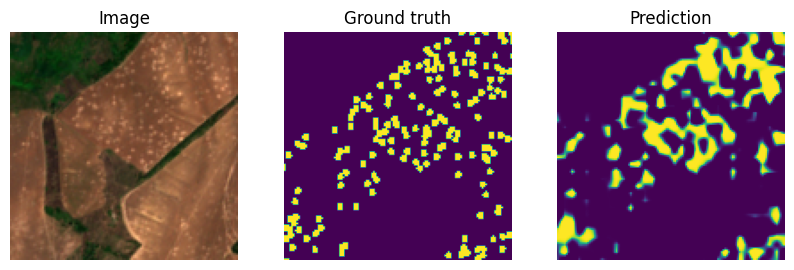

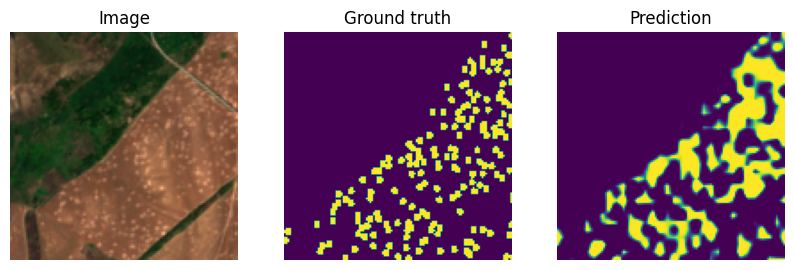

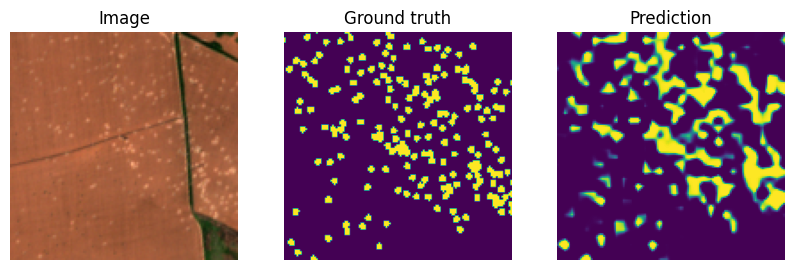

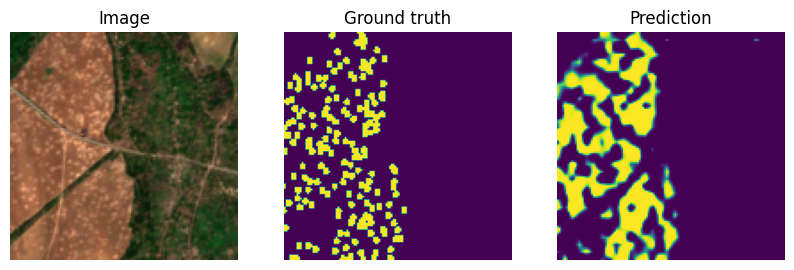

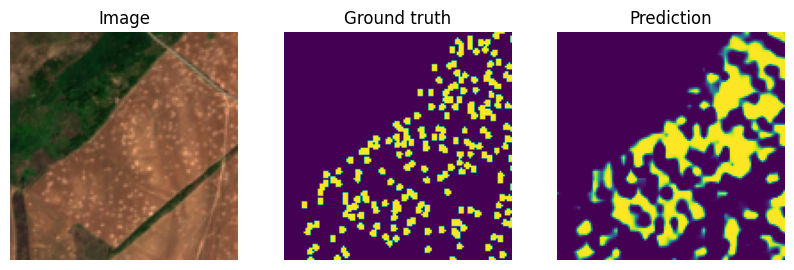

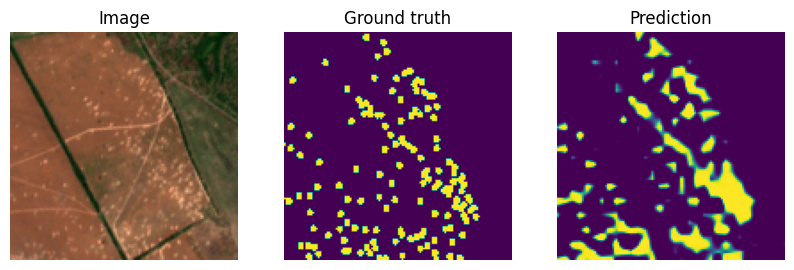

In [10]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(
        gt_mask.numpy().squeeze()
    )  # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(
        pr_mask.numpy().squeeze()
    )  # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()